In [13]:
#conda install biopython
from Bio import SeqIO
from Bio.Blast.Applications import NcbiblastpCommandline
import pandas as pd
from collections import Counter
import matplotlib.pyplot as plt
import os
import re

<h1>Step 1: data filtration by protein name</h1>
For all the sequences, including unreviewed

In [23]:
#Read the FASTA file
output_path="C:/Users/evgen/OneDrive/Desktop/filogenetyka_projekt"
fasta_file = "C:/Users/evgen/OneDrive/Desktop/filogenetyka_projekt/uniprot_seq/uniprotkb_protein_name_amylase_AND_taxo_2024_11_26.fasta"

In [6]:
#Parse the file with SeqIO
sequences = []
for record in SeqIO.parse(fasta_file, "fasta"):
    sequences.append({
        "ID": record.id,
        "Sequence": str(record.seq), 
        "Name": record.description  
    })

In [8]:
#Convert the list of dictionaries into a DataFrame
df = pd.DataFrame(sequences)
#print(df["Name"])

In [10]:
#Filter dataframe based on the 'Name' column containing specific keywords
alpha_amylase_df = df[df['Name'].str.contains('Alpha-amylase', case=False, na=False) &
                      ~df['Name'].str.contains('inhibitor', case=False, na=False)]
beta_amylase_df = df[df['Name'].str.contains('Beta-amylase', case=False, na=False) & 
                      ~df['Name'].str.contains('inhibitor', case=False, na=False)]
#alpha_amylase_inhibitor_df = df[df['Name'].str.contains('Alpha-amylase', case=False, na=False) & df['Name'].str.contains('inhibitor', case=False, na=False)]
#beta_amylase_inhibitor_df = df[df['Name'].str.contains('Beta-amylase', case=False, na=False) & df['Name'].str.contains('inhibitor', case=False, na=False)]

In [16]:
#Check the output
print("Alpha-Amylase DataFrame")
print(alpha_amylase_df["Name"])
print(alpha_amylase_df.shape)

Alpha-Amylase DataFrame
0       sp|P00693|AMY1_HORVU Alpha-amylase type A isoz...
2       sp|P17654|AMY1_ORYSJ Alpha-amylase OS=Oryza sa...
4       sp|A2YGY2|AMY2A_ORYSI Alpha-amylase isozyme 2A...
7       sp|P04063|AMY2_HORVU Alpha-amylase type B isoz...
9       sp|P08117|AMY3_WHEAT Alpha-amylase AMY3 OS=Tri...
                              ...                        
2487    tr|Q42364|Q42364_WHEAT Alpha-amylase subfamily...
2488    tr|Q42365|Q42365_WHEAT Alpha-amylase subfamily...
2489    tr|Q43003|Q43003_ORYSA Alpha-amylase (Fragment...
2517    tr|Q7M1G2|Q7M1G2_ORYSA Alpha-amylase III (Frag...
2522    tr|Q93WY2|Q93WY2_ORYSI Alpha-amylase (Fragment...
Name: Name, Length: 809, dtype: object
(809, 3)


In [18]:
print("\nBeta-Amylase DataFrame")
print(beta_amylase_df["Name"])
print(beta_amylase_df.shape)


Beta-Amylase DataFrame
3       sp|P82993|AMYB_HORVS Beta-amylase OS=Hordeum v...
10      sp|P16098|AMYB_HORVU Beta-amylase OS=Hordeum v...
53      sp|P93594|AMYB_WHEAT Beta-amylase Tri a 17 OS=...
54      sp|Q10RZ1|BAMY2_ORYSJ Beta-amylase 2, chloropl...
56      sp|Q9AV88|BAMY1_ORYSJ Beta-amylase 1, chloropl...
                              ...                        
2258    tr|B5B075|B5B075_9POAL Beta-amylase (Fragment)...
2259    tr|B5B078|B5B078_9POAL Beta-amylase (Fragment)...
2260    tr|B5B080|B5B080_9POAL Beta-amylase (Fragment)...
2261    tr|B5B081|B5B081_9POAL Beta-amylase (Fragment)...
2440    tr|K3YFG2|K3YFG2_SETIT Beta-amylase OS=Setaria...
Name: Name, Length: 1060, dtype: object
(1060, 3)


In [79]:
#print("\nAlpha-Amylase Inhibitor DataFrame")
#print(alpha_amylase_inhibitor_df["Name"])
#print(alpha_amylase_inhibitor_df.shape)

In [81]:
#print("\nBeta-Amylase Inhibitor DataFrame")
#print(beta_amylase_inhibitor_df)
#print(beta_amylase_inhibitor_df.shape)

In [20]:
def save_as_fasta(df, filename):
    with open(filename, 'w') as f:#Write to a FASTA file
        for _, row in df.iterrows():
            f.write(f">{row['ID']} {row['Name']}\n") 
            f.write(f"{row['Sequence']}\n")

In [ ]:
# Save the DataFrames as CSV files
#alpha_amylase_df.to_csv('alpha_amylase.csv', index=False)
#beta_amylase_df.to_csv('beta_amylase.csv', index=False)
#alpha_amylase_inhibitor_df.to_csv('alpha_amylase_inhibitor.csv', index=False)
#beta_amylase_inhibitor_df.to_csv('beta_amylase_inhibitor.csv', index=False)

In [22]:
# Save the DataFrames as FASTA files
#save_as_fasta(alpha_amylase_df, 'alpha_amylase.fasta')
#save_as_fasta(beta_amylase_df, 'beta_amylase.fasta')
#save_as_fasta(alpha_amylase_inhibitor_df, 'alpha_amylase_inhibitor.fasta') -> inhibitors sequeces are not taken into account in the analysis
#save_as_fasta(beta_amylase_inhibitor_df, 'beta_amylase_inhibitor.fasta') -> inhibitors sequeces are not taken into account in the analysis
save_as_fasta(alpha_amylase_df, os.path.join(output_path,'uniprot_seq/unreviewed_alpha_amylase.fasta'))
save_as_fasta(beta_amylase_df, os.path.join(output_path,'uniprot_seq/unreviewed_beta_amylase.fasta'))

<h1>Step 2: data filtarion by conservative motif</h1>

In [53]:
#Function to filter sequences based on conservative motifs
def filter_sequences(input_file, motifs, protein_name):
    with open(input_file, 'r') as infile:
        sequences = infile.readlines()

    filtered_sequences = []
    current_sequence = ""
    current_protein_name = ""

   
    for line in sequences:
        if line.startswith(">"):  

            if current_sequence and any(motif in current_sequence for motif in motifs):
                filtered_sequences.append(f">{current_protein_name}\n{current_sequence}")
            
            current_protein_name = line.strip()[1:]  
            current_sequence = ""
            
        else:
            current_sequence += line.strip()

    if current_sequence and any(motif in current_sequence for motif in motifs):
        filtered_sequences.append(f">{current_protein_name}\n{current_sequence}")

    output_file_name = os.path.join(output_path, f"uniprot_seq/{protein_name}_filtered_sequences.fasta")
    with open(output_file_name, 'w') as outfile:
        for seq in filtered_sequences:
            outfile.write(seq + "\n")

In [55]:
# alfa-amylase
motifs_1 = ["HDTG", "CIFY"] 
input_file_1 = os.path.join(output_path, os.path.join(output_path,'uniprot_seq/unreviewed_alpha_amylase.fasta'))
protein_name_1 = "alfa-amylase"

filter_sequences(input_file_1, motifs_1, protein_name_1)

In [57]:
# beta-amylase
motifs_2 = ["AGYY", "ENAL"] 
input_file_2 = os.path.join(output_path, "uniprot_seq/unreviewed_beta_amylase.fasta") 
protein_name_2 = "beta-amylase"

filter_sequences(input_file_2, motifs_2, protein_name_2)

<h1>Step 3: Filtration by sequence length</h1>

<h2>Ploting seq lengths</h2>

In [70]:
def fasta_seq_lengthes(fasta_file):
    seq_lengths={}
    with open(fasta_file) as f:
        dane=f.read()
        dane_seq = [seq for seq in dane.split(">") if seq]
        for sequence in dane_seq:
            sequence=sequence.split("\n")
            accesion=sequence[0].split()[0]
            raw_seq="".join(sequence[1:])
            seq_lengths[accesion]=len(raw_seq)
    # Create the histogram plot
    plt.hist(seq_lengths.values(), bins=50, edgecolor='black', alpha=0.7)

    plt.xlabel('Seq_length')
    plt.ylabel('Frequency')
    plt.title('Histogram of Sequence Lengths')
    ticks = range(0, max(seq_lengths.values()) + 50, 50)  # Ustawienia dla osi X co 10
    plt.xticks(ticks, fontname='Arial', fontsize=6)
    plt.show()
    #return {key:value for key, value in seq_lengths.items()}
    return [print(f'Number of sequences in the file: {len(seq_lengths.values())}')]

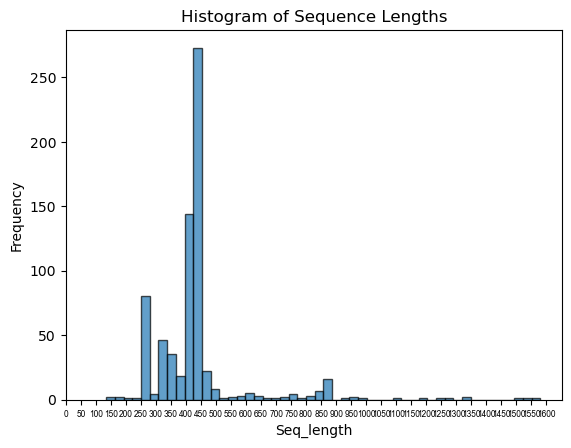

Number of sequences in the file: 698


[None]

In [83]:
filtered_alfa_amylase=os.path.join(output_path, "uniprot_seq/alfa-amylase_filtered_sequences.fasta")
fasta_seq_lengthes(filtered_alfa_amylase)

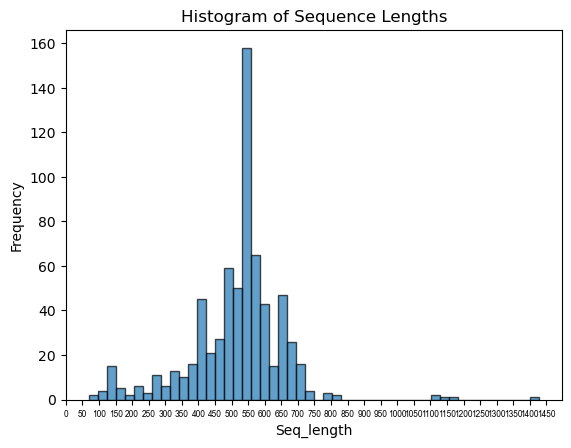

Number of sequences in the file: 679


[None]

In [86]:
filtered_beta_amylase=os.path.join(output_path, "uniprot_seq/beta-amylase_filtered_sequences.fasta")
fasta_seq_lengthes(filtered_beta_amylase)

<h2>Filtration</h2>

In [99]:
def filter_fasta_by_length(input_fasta, protein_name, min_length, max_length):
    with open(input_fasta, 'r') as infile:
        sequences = infile.read().split(">") 

    filtered_sequences = []
    
    for seq in sequences:
        if seq:  
            lines = seq.split("\n")
            accesion = lines[0].strip() 
            raw_seq = "".join(lines[1:]).strip()  
            if min_length <= len(raw_seq) <= max_length and not re.search(r"fragment", accesion, re.IGNORECASE): 
                filtered_sequences.append(f">{accesion}\n{raw_seq}")  

    output_file_name = os.path.join(output_path, f"uniprot_seq/{protein_name}_filtered_by_length.fasta")
    with open(output_file_name, 'w') as outfile:
        outfile.write("\n".join(filtered_sequences))

    print(f"Filtered sequences saved in: {output_file_name}")

In [104]:
# alfa-amylase
input_fasta_1 = os.path.join(output_path, "uniprot_seq/alfa-amylase_filtered_sequences.fasta")
protein_name_1 = "alfa-amylase"
min_length_1=250
max_length_1=900

filter_fasta_by_length(input_fasta_1, protein_name_1, min_length_1, max_length_1)

Filtered sequences saved in: C:/Users/evgen/OneDrive/Desktop/filogenetyka_projekt\uniprot_seq/alfa-amylase_filtered_by_length.fasta


In [106]:
# beta-amylase
input_fasta_2 = os.path.join(output_path, "uniprot_seq/beta-amylase_filtered_sequences.fasta")
protein_name_2 = "beta-amylase"
min_length_2=400
max_length_2=900

filter_fasta_by_length(input_fasta_2, protein_name_2, min_length_2, max_length_2)

Filtered sequences saved in: C:/Users/evgen/OneDrive/Desktop/filogenetyka_projekt\uniprot_seq/beta-amylase_filtered_by_length.fasta


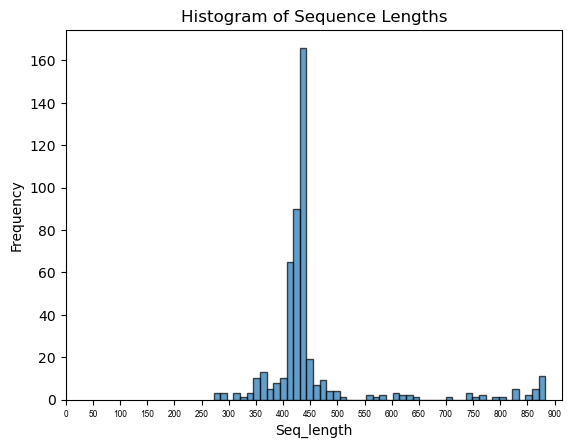

Number of sequences in the file: 469


[None]

In [110]:
lenfilt_alfa_amylase=os.path.join(output_path, "uniprot_seq/alfa-amylase_filtered_by_length.fasta")
fasta_seq_lengthes(lenfilt_alfa_amylase)

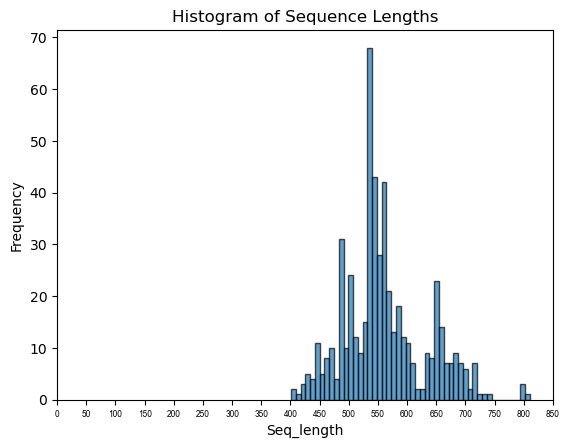

Number of sequences in the file: 527


[None]

In [112]:
lenfilt_beta_amylase=os.path.join(output_path, "uniprot_seq/beta-amylase_filtered_by_length.fasta")
fasta_seq_lengthes(lenfilt_beta_amylase)

<h1>Modify headers in FASTA file</h1>

In [134]:
def new_names(fasta_file, protein):
    
    renamed_sequences = []
    
    with open(fasta_file, 'r') as f:
        dane=f.read()
        dane_seq = [seq for seq in dane.split(">") if seq]
        
        for seq in dane_seq:
            seq=seq.split("\n")
            #sequence=">sp|P00693|AMY1_HORVU sp|P00693|AMY1_HORVU Alpha-amylase type A isozyme OS=Hordeum vulgare OX=4513 GN=AMY1.1 PE=1 SV=1"
            sequence=seq[0]
            raw_seq = "".join(seq[1:]) 
            # Podziel ciąg na słowa
            
            parts = sequence.split()
            # Wydobądź odpowiednie elementy
            protein_id = parts[1].split('|')[1]  # P00693
            # Znajdź indeks, gdzie zaczyna się 'OS='
            os_index = next(i for i, part in enumerate(parts) if part.startswith('OS='))
            ox_index = next(i for i, part in enumerate(parts) if part.startswith('OX='))
            # Pobierz nazwę białka między 2. a OS= (czyli od indeksu 2 do przed OS=)
            protein_name = ' '.join(parts[2:os_index])
            organism = ' '.join(parts[os_index:ox_index])  

            # Stwórz nowy ciąg
            new_header = f">{protein_id}|{protein_name}|{organism}"
            renamed_sequences.append(f"{new_header}\n{raw_seq}")

    # Zapisz przefiltrowane sekwencje do nowego pliku
            output_file_name = os.path.join(output_path, f"uniprot_seq/{protein}_renamed.fasta")
            with open(output_file_name, 'w') as outfile:
                for renamed_seq in renamed_sequences:
                    outfile.write(renamed_seq + "\n")
    
        print(f"Renamed sequences saved to: {output_file_name}")

In [148]:
#alfa-amylase
new_names(os.path.join(output_path, "uniprot_seq/alfa-amylase_filtered_by_length.fasta"), "alfa_amylase")

Renamed sequences saved to: C:/Users/evgen/OneDrive/Desktop/filogenetyka_projekt\uniprot_seq/alfa_amylase_renamed.fasta


In [150]:
#beta-amylase
new_names(os.path.join(output_path, "uniprot_seq/beta-amylase_filtered_by_length.fasta"), "beta_amylase")

Renamed sequences saved to: C:/Users/evgen/OneDrive/Desktop/filogenetyka_projekt\uniprot_seq/beta_amylase_renamed.fasta


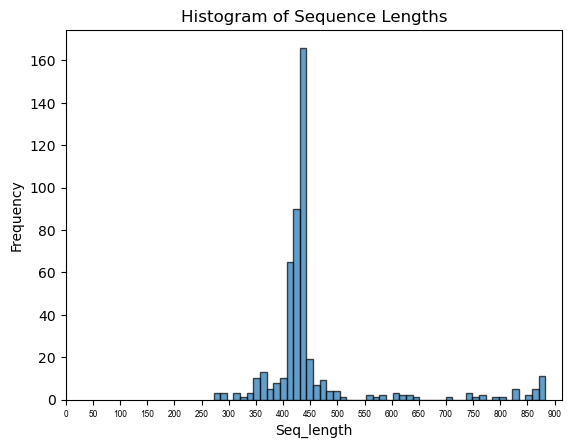

Number of sequences in the file: 469


[None]

In [151]:
#check sequences lengthes for alfa-amylase
renamed_alfa_amylase=os.path.join(output_path, "uniprot_seq/alfa_amylase_renamed.fasta")
fasta_seq_lengthes(renamed_alfa_amylase)

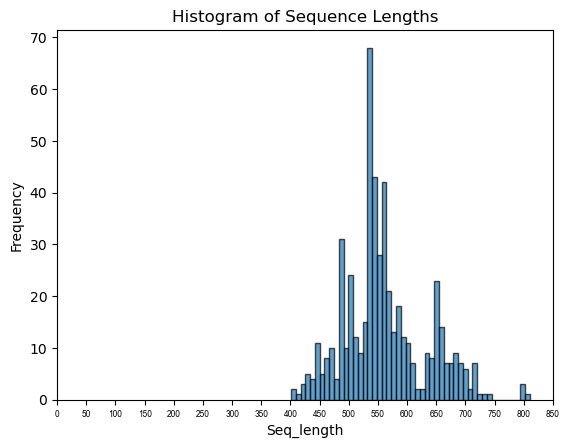

Number of sequences in the file: 527


[None]

In [154]:
#check sequences lengthes for beta-amylase
renamed_beta_amylase=os.path.join(output_path, "uniprot_seq/beta_amylase_renamed.fasta")
fasta_seq_lengthes(renamed_beta_amylase)

<h1>Create file with species names</h1>

In [47]:
# Dictionary with domestication information
domestication_data = {
        'Triticum turgidum subsp. durum': ('Domesticated', 'Around 10,000 years ago'),
        'Triticum aestivum': ('Domesticated', 'Around 10,000 years ago'),
        'Zea mays': ('Domesticated', 'Around 9,000 years ago'),
        'Hordeum vulgare subsp. vulgare': ('Domesticated', 'Around 10,000 years ago'),
        'Panicum virgatum': ('Wild', None),
        'Aegilops tauschii subsp. strangulata': ('Wild', None),
        'Sorghum bicolor': ('Domesticated', 'Around 7,000 years ago'),
        'Hordeum vulgare': ('Domesticated', 'Around 10,000 years ago'),
        'Oryza sativa subsp. japonica': ('Domesticated', 'Around 10,000 years ago'),
        'Triticum urartu': ('Wild', None),
        'Panicum miliaceum': ('Domesticated', 'Around 10,000 years ago'),
        'Setaria italica': ('Domesticated', 'Around 8,000 years ago'),
        'Oryza meridionalis': ('Wild', None),
        'Brachypodium distachyon': ('Wild', None),
        'Zizania palustris': ('Wild', None),
        'Miscanthus lutarioriparius': ('Wild', None),
        'Digitaria exilis': ('Domesticated', 'Around 7,000 years ago'),
        'Hordeum vulgare subsp. spontaneum': ('Wild', None),
        'Setaria viridis': ('Wild', None),
        'Lolium multiflorum': ('Wild', None),
        'Oryza nivara': ('Wild', None),
        'Oryza punctata': ('Wild', None),
        'Oryza rufipogon': ('Wild', None),
        'Panicum hallii': ('Wild', None),
        'Panicum hallii var. hallii': ('Wild', None),
        'Oryza glaberrima': ('Domesticated', 'Around 3,000 years ago'),
        'Oryza barthii': ('Wild', None),
        'Leersia perrieri': ('Wild', None),
        'Oryza glumipatula': ('Wild', None),
        'Eragrostis curvula': ('Wild', None),
        'Oryza sativa subsp. indica': ('Domesticated', 'Around 10,000 years ago'),
        'Aegilops tauschii': ('Wild', None),
        'Oryza meyeriana var. granulata': ('Wild', None),
        'Oryza brachyantha': ('Wild', None),
        'Dichanthelium oligosanthes': ('Wild', None),
        'Arundo donax': ('Wild', None),
        'Oryza sativa': ('Domesticated', 'Around 10,000 years ago'),
        'Saccharum hybrid cultivar R570': ('Domesticated', 'Modern hybrid'),
        'Secale cereale x Triticum turgidum subsp. durum': ('Domesticated', 'Hybrid origin, date unknown'),
        'Secale cereale': ('Domesticated', 'Around 13,000 years ago'),
        'Paspalum vaginatum': ('Wild', None),
        'Dactylis glomerata': ('Wild', None),
        'Avena fatua': ('Wild', None)
    }

    # Polish names dictionary
polish_names = {
              'Triticum turgidum subsp. durum': 'Pszenica twarda',
        'Triticum aestivum': 'Pszenica zwyczajna',
        'Zea mays': 'Kukurydza zwyczajna',
        'Hordeum vulgare subsp. vulgare': 'Jęczmień zwyczajny',
        'Panicum virgatum': 'Proso rózgowate',
        'Aegilops tauschii subsp. strangulata': '-',
        'Sorghum bicolor': 'Sorgo dwubarwne',
        'Hordeum vulgare': 'Jęczmień zwyczajny',
        'Oryza sativa subsp. japonica': 'Ryż japoński',
        'Triticum urartu': 'Pszenica urartu',
        'Panicum miliaceum': 'Proso zwyczajne',
        'Setaria italica': 'Włosica ber',
        'Oryza meridionalis': 'Ryż południowy',
        'Brachypodium distachyon': 'Wybłyszczka podwójna',
        'Zizania palustris': 'Dzika ryżowa',
        'Miscanthus lutarioriparius': 'Miskant cukrowy',
        'Digitaria exilis': 'Fonio',
        'Hordeum vulgare subsp. spontaneum': 'Jęczmień dziki',
        'Setaria viridis': 'Włosica zielona',
        'Lolium multiflorum': 'Życica wielokwiatowa',
        'Oryza nivara': 'Ryż dziki',
        'Oryza punctata': 'Ryż kropkowany',
        'Oryza rufipogon': 'Ryż czerwony',
        'Panicum hallii': 'Proso Halliego',
        'Panicum hallii var. hallii': 'Proso Halliego',
        'Oryza glaberrima': 'Ryż afrykański',
        'Oryza barthii': 'Ryż Bartha',
        'Leersia perrieri': 'Leersia Perriera',
        'Oryza glumipatula': 'Ryż południowoamerykański',
        'Eragrostis curvula': 'Miłka drobnołodygowa',
        'Oryza sativa subsp. indica': 'Ryż indyjski',
        'Aegilops tauschii': '-',
        'Oryza meyeriana var. granulata': 'Ryż Meyeriana',
        'Oryza brachyantha': 'Ryż krótkolistny',
        'Dichanthelium oligosanthes': 'Proso drobne',
        'Arundo donax': 'Trzcina pospolita',
        'Oryza sativa': 'Ryż siewny',
        'Saccharum hybrid cultivar R570': 'Cukrowiec hybrydowy',
        'Secale cereale x Triticum turgidum subsp. durum': 'Pszenżyto durum',
        'Secale cereale': 'Żyto zwyczajne',
        'Paspalum vaginatum': 'Paspalum bagienne',
        'Dactylis glomerata': 'Kupkówka pospolita',
        'Avena fatua': 'Owies głuchy'
    }


In [49]:
def species_names(fasta_file, protein):
    
    renamed_sequences = []
    
    with open(fasta_file, 'r') as f:
        dane=f.read()
        dane_seq = [seq for seq in dane.split(">") if seq]
        
        for seq in dane_seq:
            seq=seq.split("\n")
            #sequence=">sp|P00693|AMY1_HORVU sp|P00693|AMY1_HORVU Alpha-amylase type A isozyme OS=Hordeum vulgare OX=4513 GN=AMY1.1 PE=1 SV=1"
            sequence=seq[0]
            raw_seq = "".join(seq[1:]) 
            # Podziel ciąg na słowa
            
            parts = sequence.split()
            # Wydobądź odpowiednie elementy
            #protein_id = parts[1].split('|')[1]  # P00693
            # Znajdź indeks, gdzie zaczyna się 'OS='
            os_index = next(i for i, part in enumerate(parts) if part.startswith('OS='))
            ox_index = next(i for i, part in enumerate(parts) if part.startswith('OX='))
            # Pobierz nazwę białka między 2. a OS= (czyli od indeksu 2 do przed OS=)
            #protein_name = ' '.join(parts[2:os_index])
            organism = ' '.join(parts[os_index:ox_index])  

            # Stwórz nowy ciąg
            new_data = f"{organism}"
            renamed_sequences.append(f"{new_data}")

    # Zapisz przefiltrowane sekwencje do nowego pliku
            output_file_name = os.path.join(output_path, f"uniprot_seq/{protein}_species.txt")
            with open(output_file_name, 'w') as outfile:
                for renamed_seq in renamed_sequences:
                    outfile.write(renamed_seq + "\n")
        print(f"All the species names saved to: {output_file_name}")
        
        with open(output_file_name, 'r') as file:
            lines = file.readlines()
            species = [line.strip().split('=')[1] for line in lines if line.startswith('OS=')]

            # Count occurrences of each species
            species_count = Counter(species)

            # Create a DataFrame from the counts
            species_df = pd.DataFrame(species_count.items(), columns=['Species', 'Count'])


            # Map domestication data to the DataFrame
            species_df['Domestication Status'] = species_df['Species'].map(lambda x: domestication_data.get(x, ('Unknown', None))[0])
            species_df['Domestication Date'] = species_df['Species'].map(lambda x: domestication_data.get(x, ('Unknown', None))[1])

            # Add Polish names
            species_df['Polish Name'] = species_df['Species'].map(lambda x: polish_names.get(x, 'Nieznana'))

            #save as excel file
            output_excel_name = os.path.join(output_path, f"uniprot_seq/{protein}_species.xlsx")
            species_df.to_excel(output_excel_name, index=False)
            
        print(f"All the species counted in: {output_excel_name}")

        return species_df
        

In [53]:
#alfa-amylase
species_names(os.path.join(output_path, "uniprot_seq/alfa-amylase_filtered_by_length.fasta"), "alfa_amylase")

All the species names saved to: C:/Users/evgen/OneDrive/Desktop/filogenetyka_projekt\uniprot_seq/alfa_amylase_species.txt
All the species counted in: C:/Users/evgen/OneDrive/Desktop/filogenetyka_projekt\uniprot_seq/alfa_amylase_species.xlsx


,Species,Count,Domestication Status,Domestication Date,Polish Name
0,Hordeum vulgare,11,Domesticated,"Around 10,000 years ago",Jęczmień zwyczajny
1,Oryza sativa subsp. japonica,29,Domesticated,"Around 10,000 years ago",Ryż japoński
2,Oryza sativa subsp. indica,10,Domesticated,"Around 10,000 years ago",Ryż indyjski
3,Triticum aestivum,48,Domesticated,"Around 10,000 years ago",Pszenica zwyczajna
4,Oryza barthii,6,Wild,None,Ryż Bartha
5,Sorghum bicolor,18,Domesticated,"Around 7,000 years ago",Sorgo dwubarwne
6,Setaria viridis,13,Wild,None,Włosica zielona
7,Hordeum vulgare subsp. vulgare,12,Domesticated,"Around 10,000 years ago",Jęczmień zwyczajny
8,Oryza brachyantha,7,Wild,None,Ryż krótkolistny
9,Zea mays,17,Domesticated,"Around 9,000 years ago",Kukurydza zwyczajna


In [55]:
#beta-amylase
species_names(os.path.join(output_path, "uniprot_seq/beta-amylase_filtered_by_length.fasta"), "beta_amylase")

All the species names saved to: C:/Users/evgen/OneDrive/Desktop/filogenetyka_projekt\uniprot_seq/beta_amylase_species.txt
All the species counted in: C:/Users/evgen/OneDrive/Desktop/filogenetyka_projekt\uniprot_seq/beta_amylase_species.xlsx


,Species,Count,Domestication Status,Domestication Date,Polish Name
0,Hordeum vulgare subsp. spontaneum,10,Wild,None,Jęczmień dziki
1,Hordeum vulgare,19,Domesticated,"Around 10,000 years ago",Jęczmień zwyczajny
2,Triticum aestivum,49,Domesticated,"Around 10,000 years ago",Pszenica zwyczajna
3,Oryza sativa subsp. japonica,17,Domesticated,"Around 10,000 years ago",Ryż japoński
4,Saccharum hybrid cultivar R570,1,Domesticated,Modern hybrid,Cukrowiec hybrydowy
5,Arundo donax,2,Wild,None,Trzcina pospolita
6,Oryza barthii,7,Wild,None,Ryż Bartha
7,Leersia perrieri,7,Wild,None,Leersia Perriera
8,Oryza glumipatula,7,Wild,None,Ryż południowoamerykański
9,Oryza meridionalis,12,Wild,None,Ryż południowy


In [70]:
domestication_data_2 = {
    'Triticum turgidum subsp. durum': 'Domesticated',
    'Triticum aestivum': 'Domesticated',
    'Zea mays': 'Domesticated',
    'Hordeum vulgare subsp. vulgare': 'Domesticated',
    'Panicum virgatum': 'Wild',
    'Aegilops tauschii subsp. strangulata': 'Wild',
    'Sorghum bicolor': 'Domesticated',
    'Hordeum vulgare': 'Domesticated',
    'Oryza sativa subsp. japonica': 'Domesticated',
    'Triticum urartu': 'Wild',
    'Panicum miliaceum': 'Domesticated',
    'Setaria italica': 'Domesticated',
    'Oryza meridionalis': 'Wild',
    'Brachypodium distachyon': 'Wild',
    'Zizania palustris': 'Wild',
    'Miscanthus lutarioriparius': 'Wild',
    'Digitaria exilis': 'Domesticated',
    'Hordeum vulgare subsp. spontaneum': 'Wild',
    'Setaria viridis': 'Wild',
    'Lolium multiflorum': 'Wild',
    'Oryza nivara': 'Wild',
    'Oryza punctata': 'Wild',
    'Oryza rufipogon': 'Wild',
    'Panicum hallii': 'Wild',
    'Panicum hallii var. hallii': 'Wild',
    'Oryza glabrerrima': 'Domesticated',
    'Oryza barthii': 'Wild',
    'Leersia perrieri': 'Wild',
    'Oryza glumipatula': 'Wild',
    'Eragrostis curvula': 'Wild',
    'Oryza sativa subsp. indica': 'Domesticated',
    'Aegilops tauschii': 'Wild',
    'Oryza meyeriana var. granulata': 'Wild',
    'Oryza brachyantha': 'Wild',
    'Dichanthelium oligosanthes': 'Wild',
    'Arundo donax': 'Wild',
    'Oryza sativa': 'Domesticated',
    'Saccharum hybrid cultivar R570': 'Domesticated',
    'Secale cereale x Triticum turgidum subsp. durum': 'Domesticated',
    'Secale cereale': 'Domesticated',
    'Paspalum vaginatum': 'Wild',
    'Dactylis glomerata': 'Wild',
    'Avena fatua': 'Wild'}

def new_names_2(fasta_file, protein, output_path, species_data):
    renamed_sequences = []
    metadata = []  # Lista na dane metadane do ITOL

    # Wczytaj dane o gatunkach (w formacie: nazwa gatunku: status udomowienia)
    domestication_data_2 = species_data  # Zakładamy, że species_data to słownik {gatunek: status}

    with open(fasta_file, 'r') as f:
        dane = f.read()
        dane_seq = [seq for seq in dane.split(">") if seq]

        for seq in dane_seq:
            seq = seq.split("\n")
            sequence = seq[0]
            raw_seq = "".join(seq[1:])

            parts = sequence.split()
            protein_id = parts[1].split('|')[1]  # P00693
            os_index = next(i for i, part in enumerate(parts) if part.startswith('OS='))
            ox_index = next(i for i, part in enumerate(parts) if part.startswith('OX='))
            protein_name = ' '.join(parts[2:os_index])
            organism = ' '.join(parts[os_index:ox_index])

            # Sprawdź, czy gatunek jest w danych
            # Organizm jest częścią ciągu w formacie 'OS=Hordeum vulgare', więc wyodrębniamy nazwę gatunku
            species_name = organism.split('=')[1].strip()

            # Znajdź status udomowienia dla gatunku
            domestication_status = domestication_data_2.get(species_name, "Unknown")  # Domyślnie "Unknown" jeśli brak w słowniku

            # Stwórz nowy nagłówek FASTA
            new_header = f">{protein_id}|{protein_name}|{organism}"

            # Dodaj do listy przetworzonych sekwencji
            renamed_sequences.append(f"{new_header}\n{raw_seq}")

            # Dodaj metadane do listy (nagłówek FASTA + status udomowienia)
            metadata.append(f"{new_header}\t{domestication_status}")

    # Zapisz przefiltrowane sekwencje do nowego pliku FASTA
    output_file_name = os.path.join(output_path, f"uniprot_seq/{protein}_renamed_for_ITOL.fasta")
    with open(output_file_name, 'w') as outfile:
        for renamed_seq in renamed_sequences:
            outfile.write(renamed_seq + "\n")

    # Zapisz plik z metadanymi dla ITOL
    metadata_file_name = os.path.join(output_path, f"uniprot_seq/{protein}_metadata_for_ITOL.txt")
    with open(metadata_file_name, 'w') as metadata_file:
        for meta in metadata:
            metadata_file.write(meta + "\n")

    print(f"Renamed sequences saved to: {output_file_name}")
    print(f"Metadata for ITOL saved to: {metadata_file_name}")



In [78]:
#alfa-amylase
new_names_2(os.path.join(output_path, "uniprot_seq/alfa-amylase_filtered_by_length.fasta"), "alpha_amylase", output_path, domestication_data_2)

Renamed sequences saved to: C:/Users/evgen/OneDrive/Desktop/filogenetyka_projekt\uniprot_seq/alpha_amylase_renamed_for_ITOL.fasta
Metadata for ITOL saved to: C:/Users/evgen/OneDrive/Desktop/filogenetyka_projekt\uniprot_seq/alpha_amylase_metadata_for_ITOL.txt


In [76]:
#beta-amylase
new_names_2(os.path.join(output_path, "uniprot_seq/beta-amylase_filtered_by_length.fasta"), "beta_amylase", output_path, domestication_data_2)

Renamed sequences saved to: C:/Users/evgen/OneDrive/Desktop/filogenetyka_projekt\uniprot_seq/beta_amylase_renamed_for_ITOL.fasta
Metadata for ITOL saved to: C:/Users/evgen/OneDrive/Desktop/filogenetyka_projekt\uniprot_seq/beta_amylase_metadata_for_ITOL.txt


<h1>Tworzenie dotplotów z wyników dopasowanie EMBOSS</h1>

In [136]:
def parse_needle_output(file_path):
    x_coords = []
    y_coords = []
    
    with open(file_path, 'r') as file:
        lines = file.readlines()
        
        seq1_start = 0
        seq2_start = 0
        
        for line in lines:
            if line.startswith('#') or line.strip() == '':
                continue  
            
            match = re.match(r'^EMBOSS_001\s+(\d+)\s+([A-Z\-]+)\s+(\d+)', line)
            if match:
                seq1_start = int(match.group(1))
                sequence = match.group(2)
                seq2_start = int(match.group(3))
                
                for i, char in enumerate(sequence):
                    if char != '-':  # Ignoruj luki
                        x_coords.append(seq1_start)
                        y_coords.append(seq2_start)
                    
                    if char != '-':
                        seq1_start += 1
                    seq2_start += 1

    return x_coords, y_coords

In [148]:
def plot_dotplot(x_coords, y_coords, seq1_name, seq2_name):

    plt.figure(figsize=(8, 8))
    plt.scatter(x_coords, y_coords, s=0.5, color='black', alpha=1)
    plt.title(f'Dot-Plot\n {seq2_name} vs \n{seq1_name}', fontsize=14)
    plt.xlabel(f'{seq2_name}', fontsize=12)
    plt.ylabel(f'{seq1_name}', fontsize=12)
    plt.grid(True, linestyle='--', alpha=0.5)
    
    plt.xlim(0, 600)
    plt.ylim(0, 600)

    output_file=os.path.join(output_path, f"EMBOSS/{seq1_name}_{seq2_name}.png") 
    plt.savefig(output_file, format='png', dpi=300)
    #plt.close()
    plt.show()

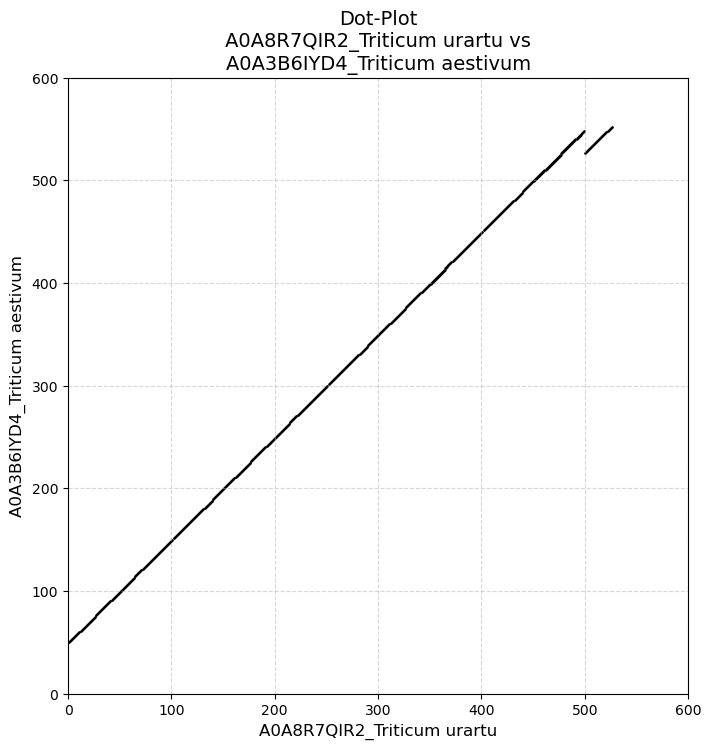

In [150]:
file_path_1 = os.path.join(output_path, f"EMBOSS/triticum_sp_emboss_needle.out") 
seq1_name_1='A0A3B6IYD4_Triticum aestivum'
seq2_name_1='A0A8R7QIR2_Triticum urartu'

x_coords_1, y_coords_1 = parse_needle_output(file_path_1)
plot_dotplot(x_coords_1, y_coords_1, seq1_name_1, seq2_name_1)

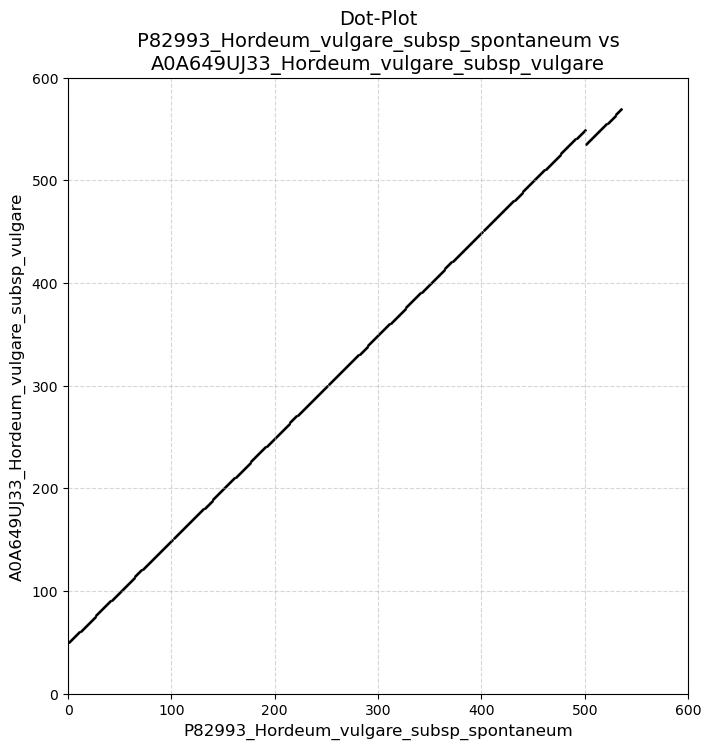

In [152]:
file_path_2 = os.path.join(output_path, f"EMBOSS/hordeum_sp_emboss_needle.out") 
seq1_name_2="A0A649UJ33_Hordeum_vulgare_subsp_vulgare"
seq2_name_2="P82993_Hordeum_vulgare_subsp_spontaneum"

x_coords_2, y_coords_2 = parse_needle_output(file_path_2)
plot_dotplot(x_coords_2, y_coords_2, seq1_name_2, seq2_name_2)

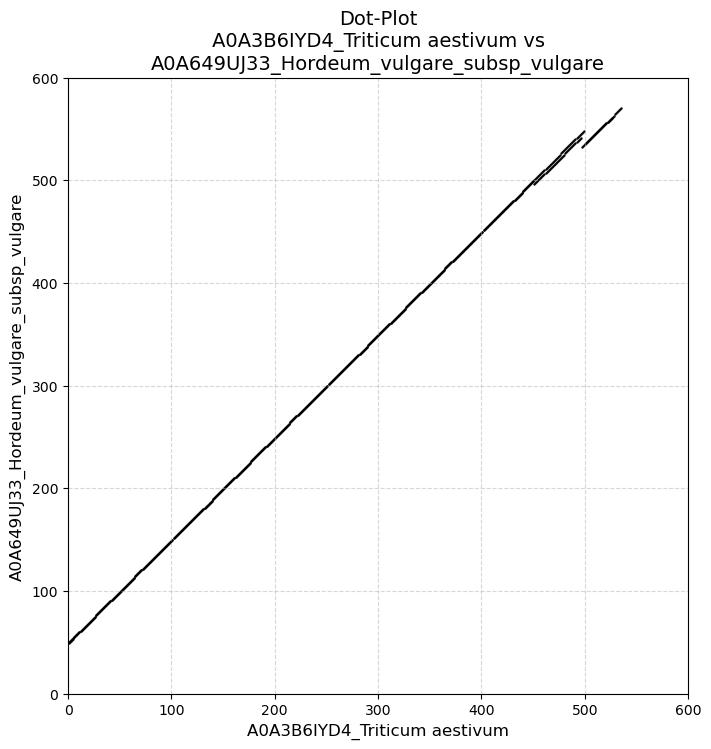

In [154]:
file_path_3 = os.path.join(output_path, f"EMBOSS/hordeum_v_v_triticum_ae.out") 
seq1_name_3="A0A649UJ33_Hordeum_vulgare_subsp_vulgare"
seq2_name_3="A0A3B6IYD4_Triticum aestivum"

x_coords_3, y_coords_3 = parse_needle_output(file_path_3)
plot_dotplot(x_coords_3, y_coords_3, seq1_name_3, seq2_name_3)